In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.signal as signal
from skimage.metrics import hausdorff_distance
import SimpleITK as sitk

In [2]:
def generate_circle(size):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + Y**2
    Z = Z < 0.5
    Z = Z.astype(np.float32)
    return Z

In [3]:
def generate_square(size):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    Z = np.ones((size, size))
    Z[(X < -0.5) | (X > 0.5)] = 0
    Z[(Y < -0.5) | (Y > 0.5)] = 0
    Z = Z.astype(np.float32)
    return Z

In [4]:
def edge_filter_mask(image):
    # Define the Sobel filter
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Apply the filter on the image
    image_x = signal.convolve2d(image, sobel_x, mode='same', boundary='symm')
    image_y = signal.convolve2d(image, sobel_y, mode='same', boundary='symm')

    # Compute the magnitude
    magnitude = np.sqrt(np.square(image_x) + np.square(image_y))

    # Compute the outline
    outline = np.zeros_like(magnitude)
    outline[magnitude > 0] = 1

    return outline

In [5]:
def convert_to_bool(image):
    image = image.astype(bool)
    return image

In [6]:
def dice_score(pred, target):
    smooth = 1.
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)

In [63]:
def ejection_fraction(ES, ED):
    projection_area_ES = np.sum(ES)
    projection_area_ED = np.sum(ED)
    return 1-np.sqrt(projection_area_ES/projection_area_ED)

In [64]:
# TESTING STUFF

In [65]:
circle = torch.from_numpy(generate_circle(64))
square = torch.from_numpy(generate_square(64))

outline_circle = convert_to_bool(edge_filter_mask(circle))
outline_square = convert_to_bool(edge_filter_mask(square))

#outline_circle = torch.from_numpy(outline_circle)
#outline_square = torch.from_numpy(outline_square)

In [66]:
dice = dice_score(circle, square)
hausdorff = hausdorff_distance(outline_circle, outline_square)

# Test metrics on masks

In [67]:
def mhd_to_array(path):
    """
    Read an *.mhd file stored in path and return it as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(path, sitk.sitkFloat32))

In [68]:
def select_cavity(mask):
    mask[mask != 1] = 0
    return mask

In [73]:
import os

root = "data/training"
patient_number = 3
pt1ed = f'patient000{patient_number}/patient000{patient_number}_2CH_ED'
pt1es = f'patient000{patient_number}/patient000{patient_number}_2CH_ES'
image_ed = mhd_to_array(os.path.join(root, pt1ed + '.mhd'))
mask_ed = mhd_to_array(os.path.join(root, pt1ed + '_gt.mhd'))

image_es = mhd_to_array(os.path.join(root, pt1es + '.mhd'))
mask_es = mhd_to_array(os.path.join(root, pt1es + '_gt.mhd'))

In [74]:
cavity_ed = select_cavity(mask_ed[0])
cavity_es = select_cavity(mask_es[0])

outline_ed = convert_to_bool(edge_filter_mask(cavity_ed))
outline_es = convert_to_bool(edge_filter_mask(cavity_es))

dice_metric = dice_score(torch.from_numpy(cavity_ed), torch.from_numpy(cavity_es))
hausdorff_metric = hausdorff_distance(outline_ed, outline_es)
EF = ejection_fraction(cavity_es, cavity_ed)

In [76]:
EF

0.21739715337753296

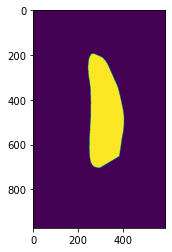

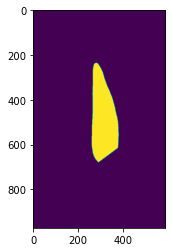

In [77]:
plt.imshow(cavity_ed)
plt.show()
plt.imshow(cavity_es)
plt.show()